In [3]:
import pandas as pd
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer,TfidfTransformer
from nltk.corpus import stopwords
import re
from textblob import TextBlob

In [31]:
dataset=pd.read_csv('train_data.csv')
#test_dataset=pd.read_csv('test_data.csv')
comments=dataset.iloc[:2000,1:]
label_=dataset.iloc[:2000,0]
#test_dataset.head()

In [32]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

In [28]:
def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = BAD_SYMBOLS_RE.sub('', text) # delete symbols which are in BAD_SYMBOLS_RE from text
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # delete stopwors from text
    return text

In [29]:
dataset['content']=dataset['content'].apply(clean_text)
#test_dataset['content']=dataset['content'].apply(clean_text)

In [8]:
def split_into_lemmas(messages):
    text=TextBlob(messages).words
    return [word.lemma for word in text]
transformer=CountVectorizer(analyzer=split_into_lemmas).fit(dataset['content'])

In [9]:
content_boe=transformer.transform(dataset['content'])
print('sparx matrix shape:',content_boe.shape)
print('nonzero',content_boe.nnz)
print('sparxity(.2f)%:',content_boe.nnz/(content_boe.shape[0]*content_boe.shape[1]))


sparx matrix shape: (30000, 40137)
nonzero
sparxity(.2f)%: 0.019592894336896132


In [10]:
print('now perform emotional classifier using multinomial detector :')
tf_idf_content=TfidfTransformer().fit(content_boe)
content_tf_idf=tf_idf_content.transform(content_boe)
MNB=MultinomialNB().fit(content_tf_idf,dataset['sentiment'])

now perform emotional classifier using multinomial detector :


In [58]:
#try first element for prediction
print(MNB.predict(tf_idf_content.transform(transformer.transform([dataset['content'][1]]))[0]))

['worry']


In [13]:
from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,classification_report
all_prediction=MNB.predict(content_tf_idf)
print('accuracy score:.2f%',accuracy_score(all_prediction,dataset['sentiment'])*100)

accuracy score:.2f% 43.38


In [54]:
#this accuracy  is not enough so we used another model for modeling
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
])
sgd.fit(dataset['content'],dataset['sentiment'])
#predict all dataset for testing purpose
predict=sgd.predict(dataset['content'])
#predict 100 th comments 
print(*sgd.predict([dataset['content'][100]]))

worry


In [ ]:
# over all accuracy 
print('accuracy_score:',accuracy_score(dataset['sentiment'],predict)*100,end="%")
print()
print(confusion_matrix(dataset['sentiment'],predict))

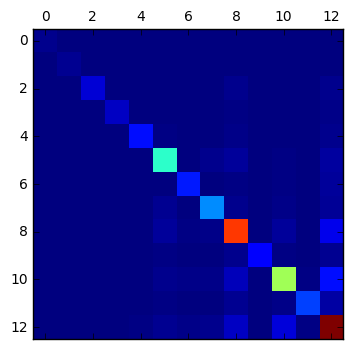

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.matshow(confusion_matrix(dataset['sentiment'],predict),cmap=plt.cm.binary,interpolation='nearest')